# 1) Feature Selection

## a) Load Libraries & Datasets

In [1]:
!pip install darts
!pip install shap

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
%matplotlib inline

import shap
import pickle
import random
import tensorflow as tf
from scipy.interpolate import interp1d
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from pytorch_lightning.callbacks import Callback
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, Add, GlobalAveragePooling1D, MultiHeadAttention, Conv1D


from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (gaussian_timeseries, linear_timeseries, sine_timeseries)
from darts.models import (RNNModel, TCNModel, TransformerModel, NBEATSModel, TFTModel, XGBModel)
from darts.metrics import mape, rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import logging
logging.disable(logging.CRITICAL)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df_bbca = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBCA.csv')
df_bbni = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBNI.csv')
df_bbri = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBRI.csv')
df_bmri = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BMRI.csv')
df_mega = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_MEGA.csv')

# Define datasets
dfs = [df_bbca, df_bbni, df_bbri, df_bmri, df_mega]
labels = ['BBCA', 'BBNI', 'BBRI', 'BMRI', 'MEGA']
labels_c0 = ['BBCA', 'BBNI', 'BMRI']
labels_c1 = ['BBRI', 'MEGA']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## b) Feature Selection using Shapley

In [4]:
def compute_shapley_importances_xgb(df, model, target_col='Close', drop_cols=['Date']):
    # Drop non-numeric columns and split data
    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]

    # Split the data into training and testing sets (e.g., 80-20 split)
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Train a RandomForest model
    model.fit(X_train, y_train)

    # Compute Shapley values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Print feature importance
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.mean(np.abs(shap_values.values), axis=0)
    }).sort_values(by='Importance', ascending=False)

    return importances

In [5]:
# USING XGBOOST

# Compute Shapley values for all datasets and combine into a single DataFrame
all_importances = []
for df, label in zip(dfs, labels):
    importances = compute_shapley_importances_xgb(df, XGBRegressor())
    importances = importances.rename(columns={'Importance': label})
    importances = importances.set_index('Feature')
    all_importances.append(importances)

# Combine all importances into a single DataFrame
combined_importances = pd.concat(all_importances, axis=1)
combined_importances['Average (Cluster 0)'] = combined_importances[['BBCA','BBNI','BMRI']].mean(axis=1)
combined_importances['Average (Cluster 1)'] = combined_importances[['BBRI','MEGA']].mean(axis=1)
combined_importances.reset_index(inplace=True)
combined_importances

,Feature,BBCA,BBNI,BBRI,BMRI,MEGA,Average (Cluster 0),Average (Cluster 1)
0,EPS,811.375271,75.384957,385.823562,677.517866,307.859734,521.426031,346.841648
1,PER,557.212714,39.099342,8.179925,48.304930,1028.494551,214.872329,518.337238
2,PTS,28.074026,650.649260,27.273924,80.510170,15.452474,253.077819,21.363199
3,ROA%,14.638861,4.220455,15.988945,7.749397,1.653246,8.869571,8.821095
4,ROE%,12.156457,1.907686,1.392162,41.024550,47.661094,18.362897,24.526628
5,PBV,4.757967,26.766148,776.638304,0.378002,64.158905,10.634039,420.398604
6,FAT,4.204570,4.393803,177.175346,3.937924,2.539526,4.178765,89.857436
7,is_idul_fitri,0.632279,0.025460,0.459256,0.001360,0.060764,0.219700,0.260010
8,is_first_2_weeks,0.348718,0.291106,1.792600,1.719869,0.158913,0.786564,0.975756
9,DER,0.283817,99.655815,9.569490,0.000000,0.000000,33.313211,4.784745


Selected Features for Cluster 0: ['EPS' 'PTS' 'PER'], Threshold: 96.92
Selected Features for Cluster 1: ['PER' 'PBV' 'EPS'], Threshold: 130.57


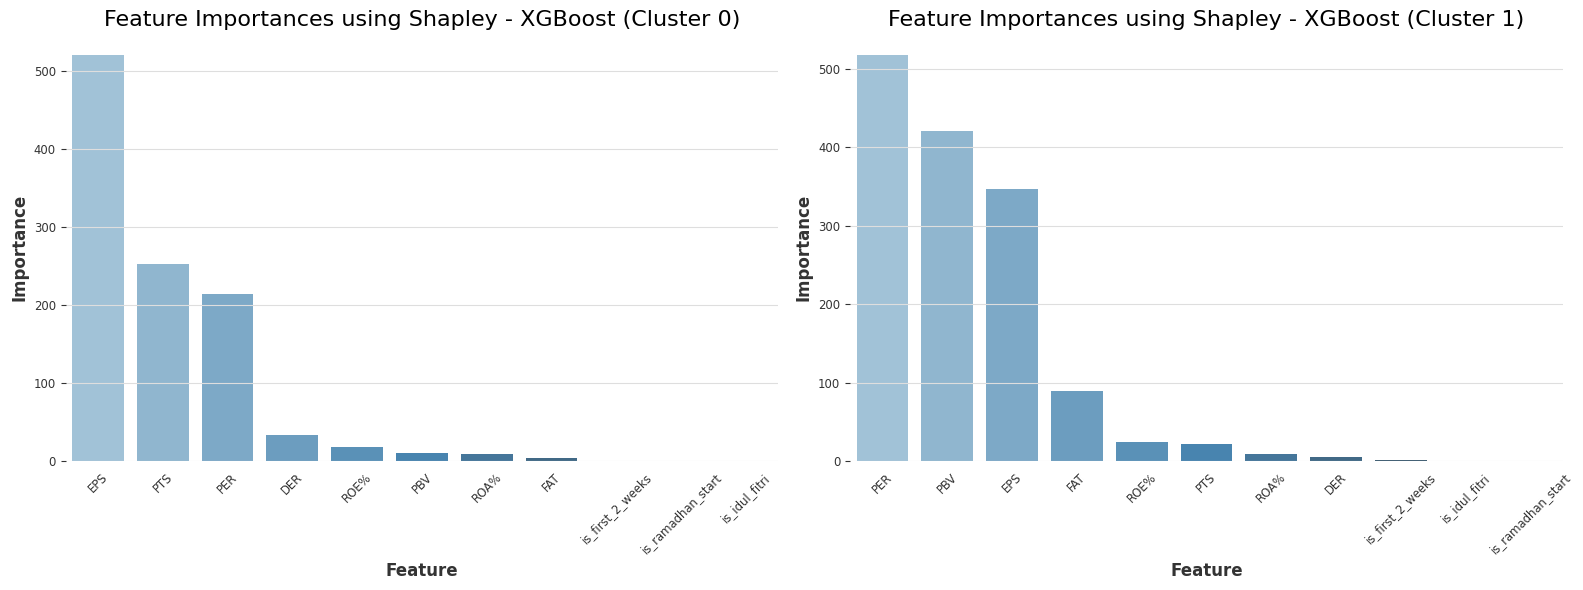

In [6]:
df_sorted = combined_importances.sort_values(by="Average (Cluster 0)", ascending=False).reset_index(drop=True)
threshold_c0 = df_sorted['Average (Cluster 0)'].mean()
selected_features_c0 = df_sorted[df_sorted['Average (Cluster 0)'] > threshold_c0]['Feature'].values

df_sorted = combined_importances.sort_values(by="Average (Cluster 1)", ascending=False).reset_index(drop=True)
threshold_c1 = df_sorted['Average (Cluster 1)'].mean()
selected_features_c1 = df_sorted[df_sorted['Average (Cluster 1)'] > threshold_c1]['Feature'].values

print(f'Selected Features for Cluster 0: {selected_features_c0}, Threshold: {round(threshold_c0, 2)}')
print(f'Selected Features for Cluster 1: {selected_features_c1}, Threshold: {round(threshold_c1, 2)}')


# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature Importances - Average (Cluster 0)
temp = combined_importances.sort_values(by='Average (Cluster 0)', ascending=False)
sns.barplot(x='Feature', y='Average (Cluster 0)', data=temp, palette="Blues_d", ax=axes[0])
axes[0].set_title("Feature Importances using Shapley - XGBoost (Cluster 0)", fontsize=16)
axes[0].set_xlabel("Feature", fontsize=12)
axes[0].set_ylabel("Importance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Feature Importances - Cluster 1
temp = combined_importances.sort_values(by='Average (Cluster 1)', ascending=False)
sns.barplot(x='Feature', y='Average (Cluster 1)', data=temp, palette="Blues_d", ax=axes[1])
axes[1].set_title("Feature Importances using Shapley - XGBoost (Cluster 1)", fontsize=16)
axes[1].set_xlabel("Feature", fontsize=12)
axes[1].set_ylabel("Importance", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show combined plot
plt.show()

# 2) Data Preprocessing

In [7]:
def data_preprocessing(df, columns):
    # Convert all variables to TimeSeries format
    price = TimeSeries.from_values(df['Close'])
    time_series_data = {col: TimeSeries.from_values(df[col]) for col in columns}

    # Stack the fundamental data to obtain series of 2 dimensions
    covariates = time_series_data[columns[0]]  # Start with 'PER' as the base
    for col in columns[1:]:  # Skip the first column since it's already included
        covariates = covariates.stack(time_series_data[col])

    # Split the covariates into training and validation sets
    train_covariates, val_covariates = covariates[:-split], covariates[-split:]

    # Scale the covariates between 0 and 1
    scaler_covariates = Scaler()
    train_covariates = scaler_covariates.fit_transform(train_covariates)
    val_covariates = scaler_covariates.transform(val_covariates)

    # Concatenate the scaled results for model input
    covariates = concatenate([train_covariates, val_covariates])

    # Scale the price data
    scaler_price = Scaler()
    price_scaled = scaler_price.fit_transform(price)
    train_df, val_df = price_scaled[:-split], price_scaled[-split:]

    return train_df, val_df, covariates, scaler_price, price_scaled

In [8]:
split = 36 # splitting point (prediksi 36 minggu ke depan)

fund_columns_all = ['PER', 'FAT', 'PTS', 'EPS', 'PBV', 'DER', 'ROE%', 'ROA%', 'is_first_2_weeks', 'is_idul_fitri', 'is_ramadhan_start']
fund_columns_c0 = ['PER', 'PTS', 'EPS']
fund_columns_c1 = ['PER', 'PBV', 'EPS']

In [9]:
train_bbca, val_bbca, covariates_bbca, scaler_bbca, price_bbca = data_preprocessing(df_bbca, fund_columns_c0)
train_bbni, val_bbni, covariates_bbni, scaler_bbni, price_bbni = data_preprocessing(df_bbni, fund_columns_c0)
train_bbri, val_bbri, covariates_bbri, scaler_bbri, price_bbri = data_preprocessing(df_bbri, fund_columns_c1)
train_bmri, val_bmri, covariates_bmri, scaler_bmri, price_bmri = data_preprocessing(df_bmri, fund_columns_c0)
train_mega, val_mega, covariates_mega, scaler_mega, price_mega = data_preprocessing(df_mega, fund_columns_c1)

train_lists_c0 = [train_bbca, train_bbni, train_bmri]
val_lists_c0 = [val_bbca, val_bbni, val_bmri]
covariates_lists_c0 = [covariates_bbca, covariates_bbni, covariates_bmri]
scalers_lists_c0 = [scaler_bbca, scaler_bbni, scaler_bmri]
price_lists_c0 = [price_bbca, price_bbni, price_bmri]
df_lists_c0 = [df_bbca, df_bbni, df_bmri]

train_lists_c1 = [train_bbri, train_mega]
val_lists_c1 = [val_bbri, val_mega]
covariates_lists_c1 = [covariates_bbri, covariates_mega]
scalers_lists_c1 = [scaler_bbri, scaler_mega]
price_lists_c1 = [price_bbri, price_mega]
df_lists_c1 = [df_bbri, df_mega]

In [10]:
train_bbca, val_bbca, covariates_bbca, scaler_bbca, price_bbca = data_preprocessing(df_bbca, fund_columns_all)
train_bbni, val_bbni, covariates_bbni, scaler_bbni, price_bbni = data_preprocessing(df_bbni, fund_columns_all)
train_bbri, val_bbri, covariates_bbri, scaler_bbri, price_bbri = data_preprocessing(df_bbri, fund_columns_all)
train_bmri, val_bmri, covariates_bmri, scaler_bmri, price_bmri = data_preprocessing(df_bmri, fund_columns_all)
train_mega, val_mega, covariates_mega, scaler_mega, price_mega = data_preprocessing(df_mega, fund_columns_all)

train_lists_c0_all = [train_bbca, train_bbni, train_bmri]
val_lists_c0_all = [val_bbca, val_bbni, val_bmri]
covariates_lists_c0_all = [covariates_bbca, covariates_bbni, covariates_bmri]
scalers_lists_c0_all = [scaler_bbca, scaler_bbni, scaler_bmri]
price_lists_c0_all = [price_bbca, price_bbni, price_bmri]
df_lists_c0_all = [df_bbca, df_bbni, df_bmri]

train_lists_c1_all = [train_bbri, train_mega]
val_lists_c1_all = [val_bbri, val_mega]
covariates_lists_c1_all = [covariates_bbri, covariates_mega]
scalers_lists_c1_all = [scaler_bbri, scaler_mega]
price_lists_c1_all = [price_bbri, price_mega]
df_lists_c1_all = [df_bbri, df_mega]

# 3) Modeling

## a) Define Functions

In [11]:
# predict model using past covariates
def predict_pastcov(train_data, val_data, model, scaler, stock_name, covariates, df, model_name):
    pred_cov = model.predict(n=36, series=train_data, past_covariates=covariates)  # Prediction 36 timestamps forward from the last training data
    pred_cov_inverse = scaler.inverse_transform(pred_cov)  # Inverse transform the scaled data
    val_inverse = scaler.inverse_transform(val_data)  # Inverse transform the validation data

    # Plot the actual and predicted values
    plt.figure(figsize=(7, 4))
    plt.plot(pd.to_datetime(df['Date']), df['Close'], label="Actual")
    plt.plot(pd.to_datetime(df['Date'][-len(pred_cov_inverse):]), pred_cov_inverse.values(), label="Forecast")

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')

    # Calculate metrics: MAPE, MAE, RMSE
    mape_score = round(mape(val_inverse, pred_cov_inverse), 2)
    mae_score = round(mae(val_inverse, pred_cov_inverse), 2)
    rmse_score = round(rmse(val_inverse, pred_cov_inverse), 2)

    # Display the metrics in the title
    plt.title(f'{stock_name} - {model_name}\nMAPE = {mape_score}%, MAE = {mae_score}, RMSE = {rmse_score}')
    plt.show()

In [12]:
# predict model using no covariates
def predict_nocov(train_data, val_data, model, scaler, stock_name, df, model_name):
    pred_cov = model.predict(n=36, series=train_data) # Prediction 36 timestamps forward from the last training data
    pred_cov_inverse = scaler.inverse_transform(pred_cov) # Inverse transform the scaled data
    val_inverse = scaler.inverse_transform(val_data)

    # Plot the actual and predicted values
    plt.figure(figsize=(7, 4))
    plt.plot(pd.to_datetime(df['Date']), df['Close'], label="actual")
    plt.plot(pd.to_datetime(df['Date'][-len(pred_cov_inverse):]), pred_cov_inverse.values(), label="forecast")

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')

    # Calculate metrics: MAPE, MAE, RMSE
    mape_score = round(mape(val_inverse, pred_cov_inverse), 2)
    mae_score = round(mae(val_inverse, pred_cov_inverse), 2)
    rmse_score = round(rmse(val_inverse, pred_cov_inverse), 2)

    # Display the metrics in the title
    plt.title(f'{stock_name} - {model_name}\nMAPE = {mape_score}%, MAE = {mae_score}, RMSE = {rmse_score}')
    plt.show()

## b) Model Training - Cluster 0

#### 1) With All Covariates

In [13]:
# help(XGBModel)

In [14]:
model_name = "XGBoost_test"
model_xgb = XGBModel(
    lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags=24,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    # **generate_torch_kwargs()
)

# Fit the model
model_xgb.fit(
    series=train_lists_c0_all,
    past_covariates=covariates_lists_c0_all,
    val_series=val_lists_c0_all,
    val_past_covariates=covariates_lists_c0_all,
)


[0]	validation_0-rmse:0.35155
[1]	validation_0-rmse:0.29876
[2]	validation_0-rmse:0.25492
[3]	validation_0-rmse:0.22824
[4]	validation_0-rmse:0.20501
[5]	validation_0-rmse:0.18855
[6]	validation_0-rmse:0.18066
[7]	validation_0-rmse:0.17298
[8]	validation_0-rmse:0.16690
[9]	validation_0-rmse:0.16218
[10]	validation_0-rmse:0.15959
[11]	validation_0-rmse:0.15756
[12]	validation_0-rmse:0.15600
[13]	validation_0-rmse:0.15432
[14]	validation_0-rmse:0.15315
[15]	validation_0-rmse:0.15244
[16]	validation_0-rmse:0.15161
[17]	validation_0-rmse:0.15083
[18]	validation_0-rmse:0.15071
[19]	validation_0-rmse:0.15064
[20]	validation_0-rmse:0.15057
[21]	validation_0-rmse:0.15055
[22]	validation_0-rmse:0.15046
[23]	validation_0-rmse:0.14999
[24]	validation_0-rmse:0.14989
[25]	validation_0-rmse:0.14975
[26]	validation_0-rmse:0.14966
[27]	validation_0-rmse:0.14961
[28]	validation_0-rmse:0.14940
[29]	validation_0-rmse:0.14933
[30]	validation_0-rmse:0.14927
[31]	validation_0-rmse:0.14917
[32]	validation_0-

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

In [15]:
model_xgb

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

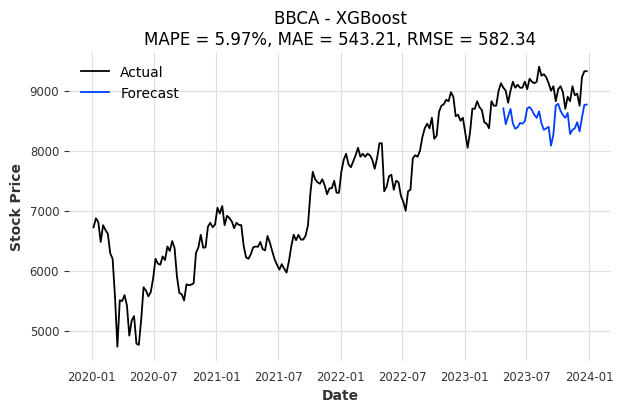

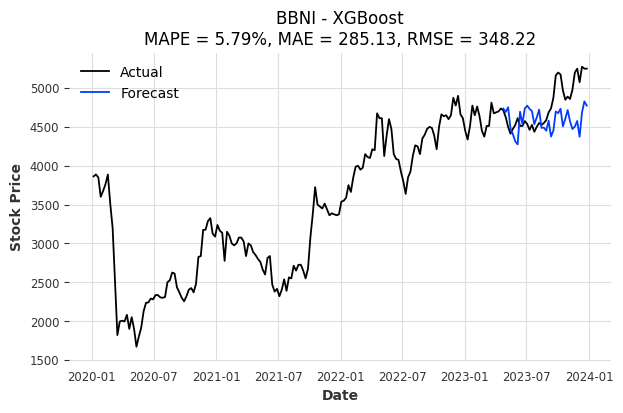

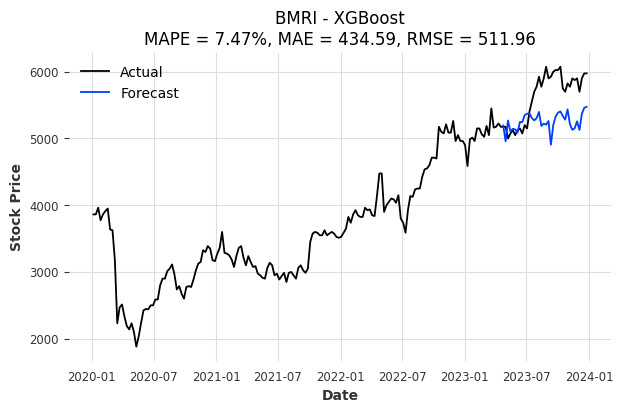

In [16]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c0_all, val_lists_c0_all, scalers_lists_c0_all, labels_c0, covariates_lists_c0_all, df_lists_c0_all):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_xgb, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='XGBoost')

#### 2) With Shapley Covariates

In [17]:
# help(XGBModel)

In [18]:
model_name = "XGBoost_test"
model_xgb = XGBModel(
    lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags=24,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    # **generate_torch_kwargs()
)

# Fit the model
model_xgb.fit(
    series=train_lists_c0,
    past_covariates=covariates_lists_c0,
    val_series=val_lists_c0,
    val_past_covariates=covariates_lists_c0,
)


[0]	validation_0-rmse:0.35219
[1]	validation_0-rmse:0.29118
[2]	validation_0-rmse:0.25034
[3]	validation_0-rmse:0.21844
[4]	validation_0-rmse:0.19769
[5]	validation_0-rmse:0.18655
[6]	validation_0-rmse:0.17728
[7]	validation_0-rmse:0.16969
[8]	validation_0-rmse:0.16306
[9]	validation_0-rmse:0.15896
[10]	validation_0-rmse:0.15728
[11]	validation_0-rmse:0.15534
[12]	validation_0-rmse:0.15367
[13]	validation_0-rmse:0.15163
[14]	validation_0-rmse:0.15098
[15]	validation_0-rmse:0.15054
[16]	validation_0-rmse:0.15028
[17]	validation_0-rmse:0.14969
[18]	validation_0-rmse:0.14924
[19]	validation_0-rmse:0.14911
[20]	validation_0-rmse:0.14913
[21]	validation_0-rmse:0.14872
[22]	validation_0-rmse:0.14872
[23]	validation_0-rmse:0.14858
[24]	validation_0-rmse:0.14839
[25]	validation_0-rmse:0.14837
[26]	validation_0-rmse:0.14849
[27]	validation_0-rmse:0.14827
[28]	validation_0-rmse:0.14828
[29]	validation_0-rmse:0.14816
[30]	validation_0-rmse:0.14810
[31]	validation_0-rmse:0.14811
[32]	validation_0-

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

In [19]:
model_xgb

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

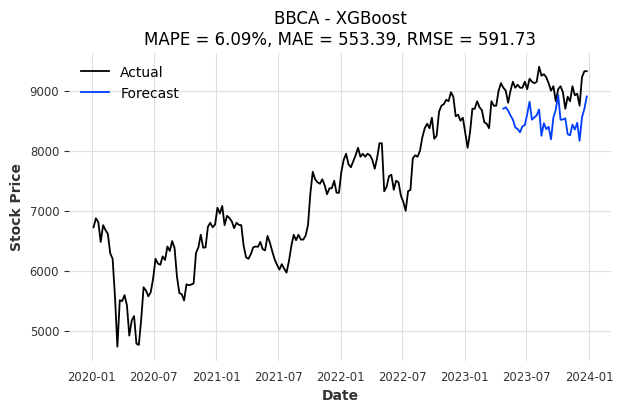

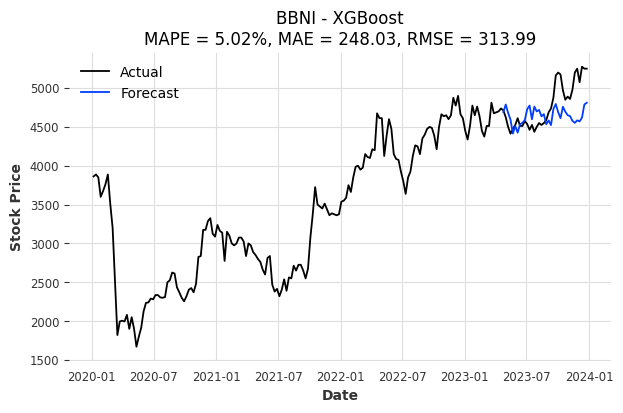

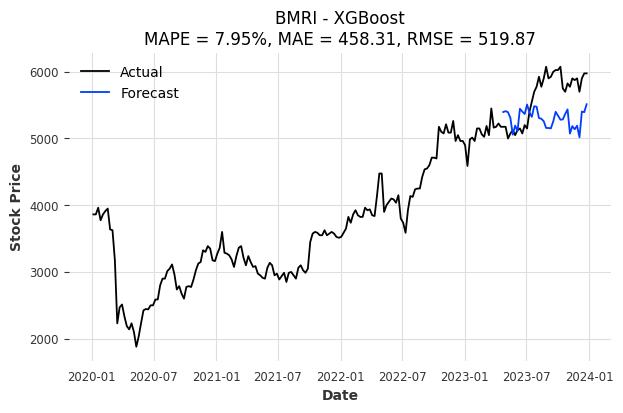

In [20]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c0, val_lists_c0, scalers_lists_c0, labels_c0, covariates_lists_c0, df_lists_c0):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_xgb, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='XGBoost')

#### 3) No Covariates

In [21]:
model_name = "XGBoost_test"
model_xgb_nocov = XGBModel(
    lags=24,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    # **generate_torch_kwargs()
)

model_xgb_nocov.fit(
    series=train_lists_c0,
    val_series=val_lists_c0
)

[0]	validation_0-rmse:0.34813
[1]	validation_0-rmse:0.27925
[2]	validation_0-rmse:0.23266
[3]	validation_0-rmse:0.20439
[4]	validation_0-rmse:0.18428
[5]	validation_0-rmse:0.17077
[6]	validation_0-rmse:0.16378
[7]	validation_0-rmse:0.15851
[8]	validation_0-rmse:0.15406
[9]	validation_0-rmse:0.15122
[10]	validation_0-rmse:0.14731
[11]	validation_0-rmse:0.14606
[12]	validation_0-rmse:0.14443
[13]	validation_0-rmse:0.14340
[14]	validation_0-rmse:0.14262
[15]	validation_0-rmse:0.14152
[16]	validation_0-rmse:0.14052
[17]	validation_0-rmse:0.14025
[18]	validation_0-rmse:0.13970
[19]	validation_0-rmse:0.13925
[20]	validation_0-rmse:0.13937
[21]	validation_0-rmse:0.13945
[22]	validation_0-rmse:0.13921
[23]	validation_0-rmse:0.13940
[24]	validation_0-rmse:0.13934
[25]	validation_0-rmse:0.13924
[26]	validation_0-rmse:0.13925
[27]	validation_0-rmse:0.13917
[28]	validation_0-rmse:0.13917
[29]	validation_0-rmse:0.13904
[30]	validation_0-rmse:0.13896
[31]	validation_0-rmse:0.13898
[32]	validation_0-

XGBModel(lags=24, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

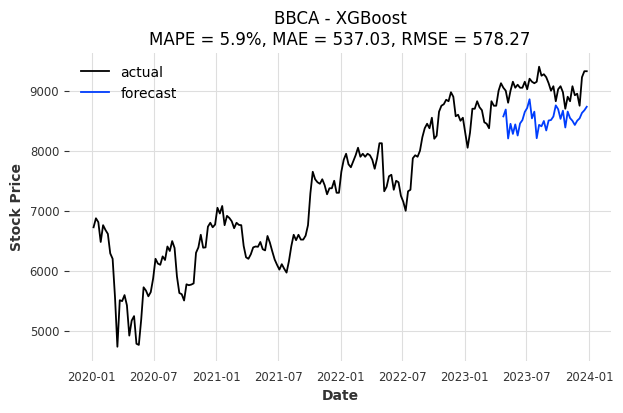

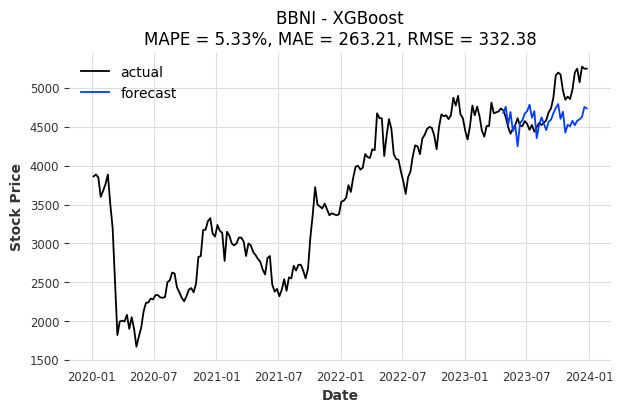

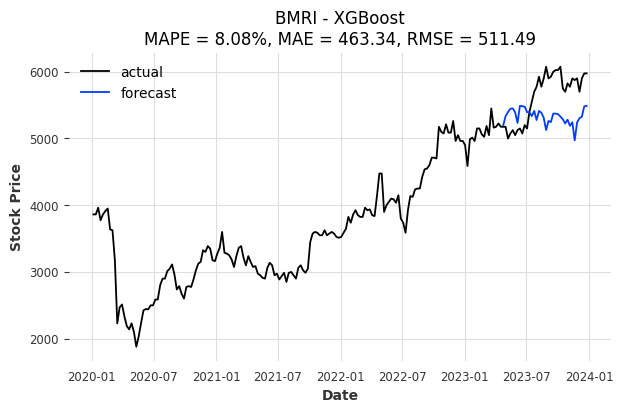

In [22]:
# Loop through the training, validation, and lists
for train, val, scaler, stock, df in zip(train_lists_c0, val_lists_c0, scalers_lists_c0, labels_c0, df_lists_c0):
    predict_nocov(train_data=train, val_data=val,
                   model=model_xgb_nocov, scaler=scaler,
                   stock_name=stock, df=df, model_name='XGBoost')

## c) Model Training - Cluster 1

#### 1) With All Covariates

In [23]:
# help(XGBModel)

In [24]:
model_name = "XGBoost_test"
model_xgb = XGBModel(
    lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags=24,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    # **generate_torch_kwargs()
)

# Fit the model
model_xgb.fit(
    series=train_lists_c1_all,
    past_covariates=covariates_lists_c1_all,
    val_series=val_lists_c1_all,
    val_past_covariates=covariates_lists_c1_all,
)


[0]	validation_0-rmse:0.22574
[1]	validation_0-rmse:0.20699
[2]	validation_0-rmse:0.19477
[3]	validation_0-rmse:0.18266
[4]	validation_0-rmse:0.17144
[5]	validation_0-rmse:0.16177
[6]	validation_0-rmse:0.15424
[7]	validation_0-rmse:0.14616
[8]	validation_0-rmse:0.13949
[9]	validation_0-rmse:0.13502
[10]	validation_0-rmse:0.13061
[11]	validation_0-rmse:0.12782
[12]	validation_0-rmse:0.12644
[13]	validation_0-rmse:0.12416
[14]	validation_0-rmse:0.12339
[15]	validation_0-rmse:0.12196
[16]	validation_0-rmse:0.12154
[17]	validation_0-rmse:0.11996
[18]	validation_0-rmse:0.11961
[19]	validation_0-rmse:0.11886
[20]	validation_0-rmse:0.11765
[21]	validation_0-rmse:0.11761
[22]	validation_0-rmse:0.11736
[23]	validation_0-rmse:0.11631
[24]	validation_0-rmse:0.11609
[25]	validation_0-rmse:0.11579
[26]	validation_0-rmse:0.11485
[27]	validation_0-rmse:0.11477
[28]	validation_0-rmse:0.11476
[29]	validation_0-rmse:0.11419
[30]	validation_0-rmse:0.11372
[31]	validation_0-rmse:0.11356
[32]	validation_0-

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

In [25]:
model_xgb

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

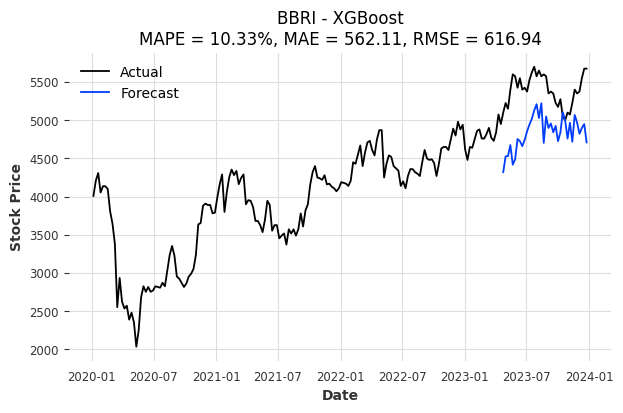

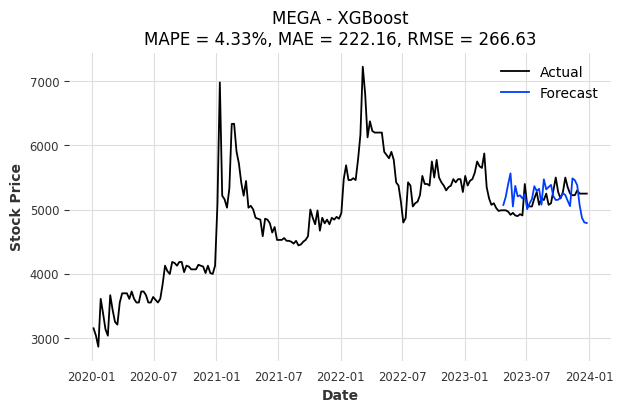

In [26]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c1_all, val_lists_c1_all, scalers_lists_c1_all, labels_c1, covariates_lists_c1_all, df_lists_c1_all):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_xgb, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='XGBoost')

#### 2) With Shapley Covariates

In [27]:
# help(XGBModel)

In [28]:
model_name = "XGBoost_test"
model_xgb = XGBModel(
    lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
    lags=24,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    # **generate_torch_kwargs()
)

# Fit the model
model_xgb.fit(
    series=train_lists_c1,
    past_covariates=covariates_lists_c1,
    val_series=val_lists_c1,
    val_past_covariates=covariates_lists_c1,
)


[0]	validation_0-rmse:0.24575
[1]	validation_0-rmse:0.23125
[2]	validation_0-rmse:0.22104
[3]	validation_0-rmse:0.20665
[4]	validation_0-rmse:0.19603
[5]	validation_0-rmse:0.19067
[6]	validation_0-rmse:0.17880
[7]	validation_0-rmse:0.17153
[8]	validation_0-rmse:0.16656
[9]	validation_0-rmse:0.16355
[10]	validation_0-rmse:0.15849
[11]	validation_0-rmse:0.15622
[12]	validation_0-rmse:0.15594
[13]	validation_0-rmse:0.15547
[14]	validation_0-rmse:0.15414
[15]	validation_0-rmse:0.15314
[16]	validation_0-rmse:0.15267
[17]	validation_0-rmse:0.15118
[18]	validation_0-rmse:0.15091
[19]	validation_0-rmse:0.15004
[20]	validation_0-rmse:0.14914
[21]	validation_0-rmse:0.14835
[22]	validation_0-rmse:0.14732
[23]	validation_0-rmse:0.14731
[24]	validation_0-rmse:0.14703
[25]	validation_0-rmse:0.14673
[26]	validation_0-rmse:0.14648
[27]	validation_0-rmse:0.14601
[28]	validation_0-rmse:0.14544
[29]	validation_0-rmse:0.14541
[30]	validation_0-rmse:0.14458
[31]	validation_0-rmse:0.14433
[32]	validation_0-

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

In [29]:
model_xgb

XGBModel(lags=24, lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

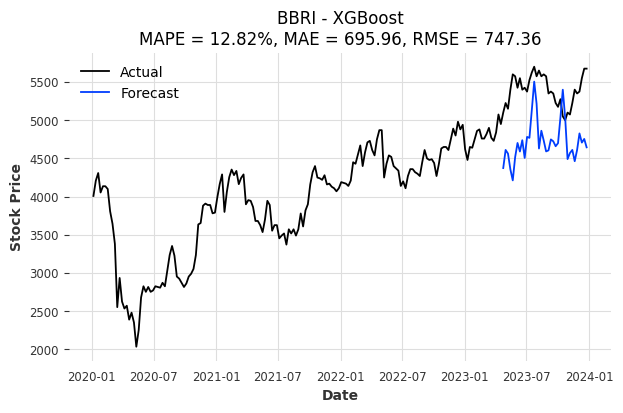

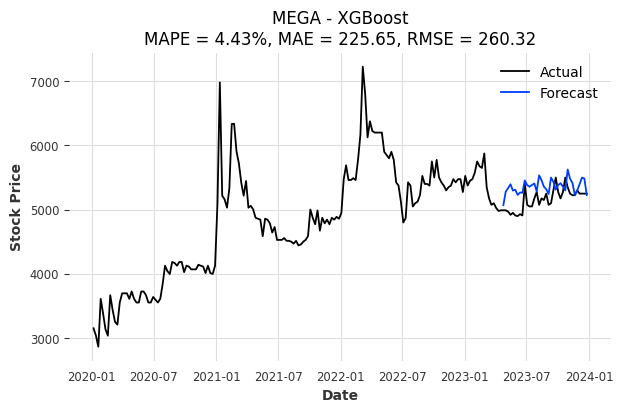

In [30]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c1, val_lists_c1, scalers_lists_c1, labels_c1, covariates_lists_c1, df_lists_c1):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_xgb, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='XGBoost')

#### 3) No Covariates

In [31]:
model_name = "XGBoost_test"
model_xgb_nocov = XGBModel(
    lags=24,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    # **generate_torch_kwargs()
)

model_xgb_nocov.fit(
    series=train_lists_c1,
    val_series=val_lists_c1
)

[0]	validation_0-rmse:0.24270
[1]	validation_0-rmse:0.23445
[2]	validation_0-rmse:0.22008
[3]	validation_0-rmse:0.20893
[4]	validation_0-rmse:0.20179
[5]	validation_0-rmse:0.19725
[6]	validation_0-rmse:0.19357
[7]	validation_0-rmse:0.19032
[8]	validation_0-rmse:0.18716
[9]	validation_0-rmse:0.18642
[10]	validation_0-rmse:0.18479
[11]	validation_0-rmse:0.18327
[12]	validation_0-rmse:0.18297
[13]	validation_0-rmse:0.18211
[14]	validation_0-rmse:0.18137
[15]	validation_0-rmse:0.18055
[16]	validation_0-rmse:0.17996
[17]	validation_0-rmse:0.17981
[18]	validation_0-rmse:0.17988
[19]	validation_0-rmse:0.17973
[20]	validation_0-rmse:0.17974
[21]	validation_0-rmse:0.17963
[22]	validation_0-rmse:0.17994
[23]	validation_0-rmse:0.17977
[24]	validation_0-rmse:0.17969
[25]	validation_0-rmse:0.17935
[26]	validation_0-rmse:0.17937
[27]	validation_0-rmse:0.17918
[28]	validation_0-rmse:0.17918
[29]	validation_0-rmse:0.17925
[30]	validation_0-rmse:0.17923
[31]	validation_0-rmse:0.17928
[32]	validation_0-

XGBModel(lags=24, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True, batch_size=8, n_epochs=100, input_chunk_length=24, model_name=XGBoost_test, save_checkpoints=True, force_reset=True)

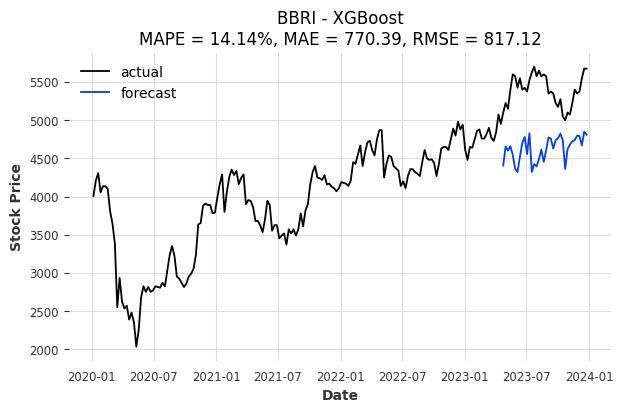

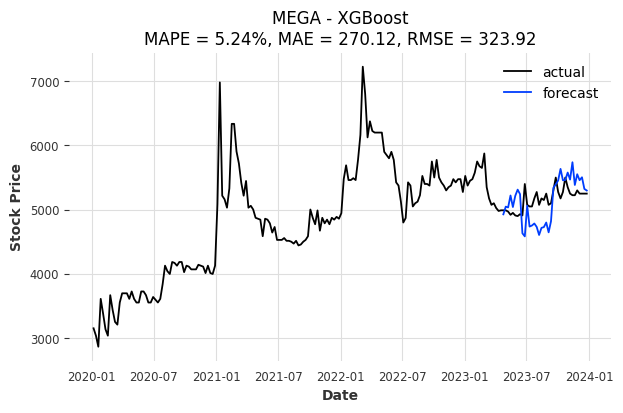

In [32]:
# Loop through the training, validation, and lists
for train, val, scaler, stock, df in zip(train_lists_c1, val_lists_c1, scalers_lists_c1, labels_c1, df_lists_c1):
    predict_nocov(train_data=train, val_data=val,
                   model=model_xgb_nocov, scaler=scaler,
                   stock_name=stock, df=df, model_name='XGBoost')